## Import packages

In [4]:
import pandas as pd
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
import json

from deep_translator import GoogleTranslator
from langdetect import detect
from fuzzywuzzy import process
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder
from recipe_scrapers import scrape_me

## Translation part

In [11]:
df_ingredients = pd.read_csv('ingredients.csv', index_col=0)
ing_list = df_ingredients['Ingredients'].to_list()
ing_list_translated = GoogleTranslator(source=detect(', '.join(ing_list)), target='en').translate_batch(ing_list) # Brings all the ingredients into a corpus to best detect the language
df_ingredients['Ingredient_Translated'] = ing_list_translated

## Populating food category

### Fuzzywuzzy to select closest food category, best classification model to fill in the rest

In [53]:
# Load the food and category data into a Pandas dataframe
df_foods = pd.read_csv("foods.csv")

# Convert the DataFrame to a dictionary, with the first column as the keys and the second column as the values
data_dict = df_foods.set_index(df_foods.columns[0]).to_dict()[df_foods.columns[1]]
reverse = {}
for k, v in data_dict.items():
    if v in reverse:
        reverse[v] += (k,)
    else:
        reverse[v] = (k,)

# Write the dictionary to a JSON file
with open('foods.json', 'w') as json_file:
    json.dump(reverse, json_file)

In [55]:
with open('foods.json') as f:
    foods_json = json.load(f)

df = pd.DataFrame(columns=['Category', 'Food'])

for category, foods in foods_json.items():
    for food in foods:
        df = df.append({'Category': category, 'Food': food}, ignore_index=True)

df

,Category,Food
0,Dairy,Cows' milk
1,Dairy,Milk skim
2,Dairy,Buttermilk
3,Dairy,"Evaporated, undiluted"
4,Dairy,Fortified milk
...,...,...
314,Drinks,Fruit-flavored soda
315,Drinks,Ginger ale
316,Drinks,Root beer
317,Drinks,Coffee


In [29]:
# fuzzywuzzy match
score_cutoff = 90 # the higher this is, the more strict fuzzywuzzy is in looking for a match 

df_ingredients['match'] = df_ingredients['Ingredient_Translated'].apply(
    lambda x: process.extractOne(x, df_foods['Food'].tolist(), score_cutoff=score_cutoff)[0] if process.extractOne(x, df_foods['Food'].tolist(), score_cutoff=score_cutoff) else 'Unknown'
)

# create mapping
mapping = df_foods.set_index('Food').to_dict()['Category']
df_ingredients['Category'] = df_ingredients['match'].map(mapping)

# fill missing values with classifier
classifier = joblib.load('trained_SVC_model.joblib')
missing_mask = df_ingredients['Category'].isnull()
missing_data = df_ingredients[missing_mask].drop(['Category', 'match'], axis=1)

# Vectorize the ingredients using the same bag of words representation
vectorizer = joblib.load('vectorizer.joblib')
ingredients_vectorized = vectorizer.transform(missing_data['Ingredient_Translated'].to_list())

# make predictions using the classifier
predictions = classifier.predict(ingredients_vectorized)
df_ingredients.loc[missing_mask, 'Category'] = predictions

# fill remaining missing values with 'Unknown'
df_ingredients.loc[df_ingredients['Category'].isnull(), 'Category'] = 'Unknown'
cols = ['Ingredient_Translated', 'match']
df_ingredients = df_ingredients.drop(columns=cols, axis=1)
df_ingredients

,Category,Ingredients,Measurement,Total,shakshuka-met-verse-geitenkaas,kipfilethaasjes-in-zoete-saus-met-knoflookrijst,gevulde-paprika-met-chili-con-carne,snelle-spaghetti-bolognese-met-ontbijtspek,romige-aardappelschotel-met-warmgerookte-zalm
0,Grains,Basmatirijst,gram,80.00,0.0,0.00,80.0,0.0,0.0
1,Vegetables,Rode kidneybonen,pak(ken),1.00,0.0,0.00,1.0,0.0,0.0
2,Grains,Spaghetti,gram,180.00,0.0,0.00,0.0,180.0,0.0
3,Vegetables,Aardappelen,gram,400.00,0.0,0.00,0.0,0.0,400.0
4,Vegetables,Groene paprika,stuk(s),2.00,0.0,0.00,2.0,0.0,0.0
5,Vegetables,Knoflookteen,stuk(s),6.00,2.0,2.00,0.0,2.0,0.0
6,Vegetables,Paprika,stuk(s),2.00,1.0,0.00,1.0,0.0,0.0
7,Vegetables,Prei,stuk(s),1.00,0.0,0.00,0.0,0.0,1.0
8,Vegetables,Rode peper,stuk(s),1.00,0.5,0.00,0.5,0.0,0.0
9,Vegetables,Rucola,gram,40.00,0.0,0.00,0.0,40.0,0.0


## Classification modeling

### Training SVC model and vectorizer

In [5]:
# Load the food and category data into a Pandas dataframe
df_foods = pd.read_csv("foods.csv")

# Create a bag of words representation of the food items
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df_foods['Food'])

# Train a Linear SVC classifier on the data
classifier = SVC()
classifier.fit(X, df_foods['Category'])

# Save the model and vectorizer to disk
filename = 'trained_SVC_model.joblib'
joblib.dump(classifier, filename)

filename = 'vectorizer.joblib'
joblib.dump(vectorizer, filename)

['vectorizer.joblib']

### Exploring the best model

Classifier: MultinomialNB, Accuracy: 0.402 (+/- 0.085)


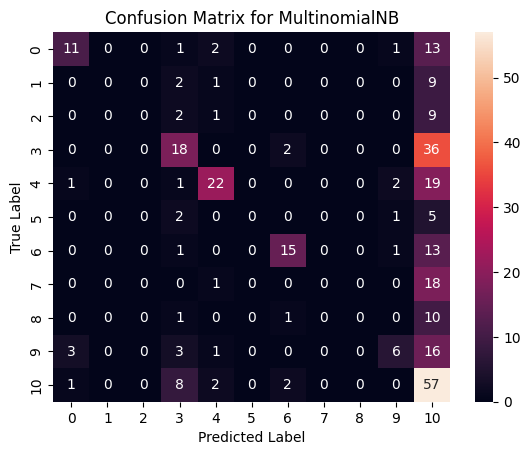

Classification Report for MultinomialNB:
                precision    recall  f1-score   support

         Dairy       0.69      0.39      0.50        28
        Drinks       0.00      0.00      0.00        12
   Fats & Oils       0.00      0.00      0.00        12
        Fruits       0.46      0.32      0.38        56
        Grains       0.73      0.49      0.59        45
Jams & Jellies       0.00      0.00      0.00         8
          Meat       0.75      0.50      0.60        30
       Seafood       0.00      0.00      0.00        19
  Seeds & Nuts       0.00      0.00      0.00        12
        Sweets       0.55      0.21      0.30        29
    Vegetables       0.28      0.81      0.41        70

      accuracy                           0.40       321
     macro avg       0.31      0.25      0.25       321
  weighted avg       0.42      0.40      0.37       321



/Users/junerodriguez/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/junerodriguez/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/junerodriguez/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

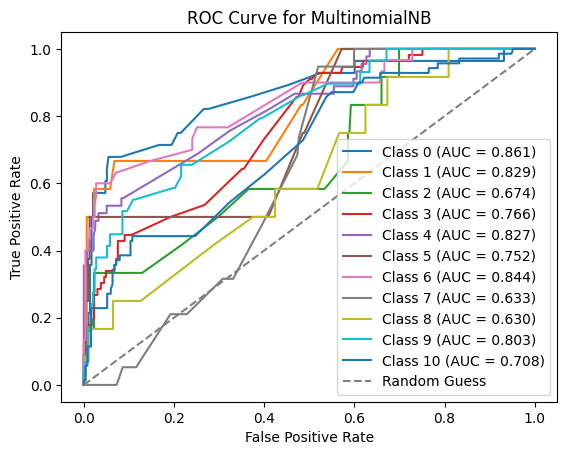

Classifier: SVC, Accuracy: 0.420 (+/- 0.062)


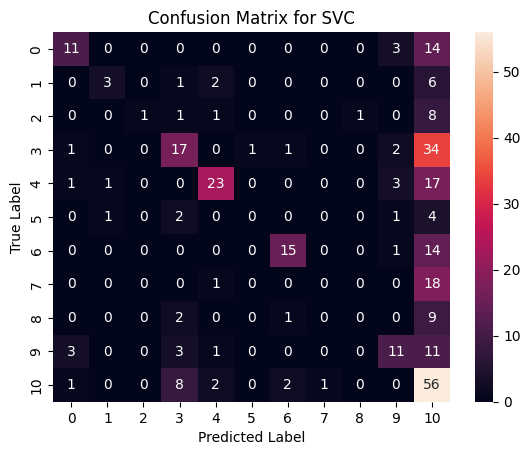

Classification Report for SVC:
                precision    recall  f1-score   support

         Dairy       0.65      0.39      0.49        28
        Drinks       0.60      0.25      0.35        12
   Fats & Oils       1.00      0.08      0.15        12
        Fruits       0.50      0.30      0.38        56
        Grains       0.77      0.51      0.61        45
Jams & Jellies       0.00      0.00      0.00         8
          Meat       0.79      0.50      0.61        30
       Seafood       0.00      0.00      0.00        19
  Seeds & Nuts       0.00      0.00      0.00        12
        Sweets       0.52      0.38      0.44        29
    Vegetables       0.29      0.80      0.43        70

      accuracy                           0.43       321
     macro avg       0.47      0.29      0.32       321
  weighted avg       0.50      0.43      0.40       321



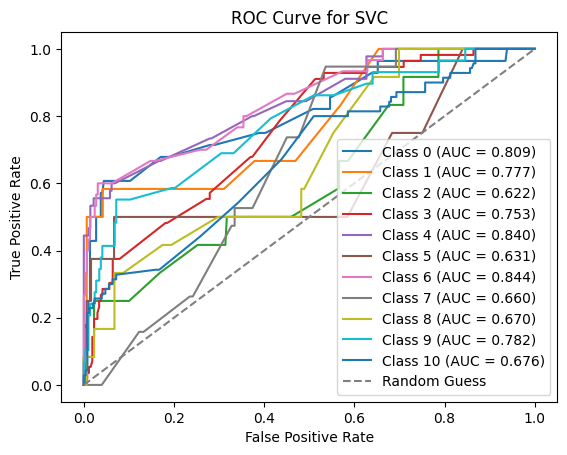

Classifier: DecisionTree, Accuracy: 0.408 (+/- 0.118)


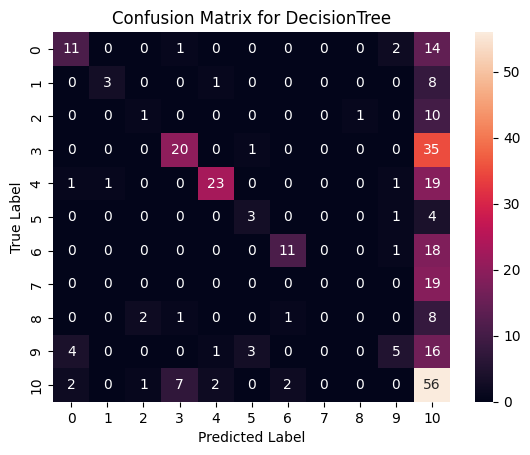

Classification Report for DecisionTree:
                precision    recall  f1-score   support

         Dairy       0.61      0.39      0.48        28
        Drinks       0.75      0.25      0.38        12
   Fats & Oils       0.25      0.08      0.12        12
        Fruits       0.69      0.36      0.47        56
        Grains       0.85      0.51      0.64        45
Jams & Jellies       0.43      0.38      0.40         8
          Meat       0.79      0.37      0.50        30
       Seafood       0.00      0.00      0.00        19
  Seeds & Nuts       0.00      0.00      0.00        12
        Sweets       0.50      0.17      0.26        29
    Vegetables       0.27      0.80      0.40        70

      accuracy                           0.41       321
     macro avg       0.47      0.30      0.33       321
  weighted avg       0.52      0.41      0.40       321



/Users/junerodriguez/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/junerodriguez/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/junerodriguez/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

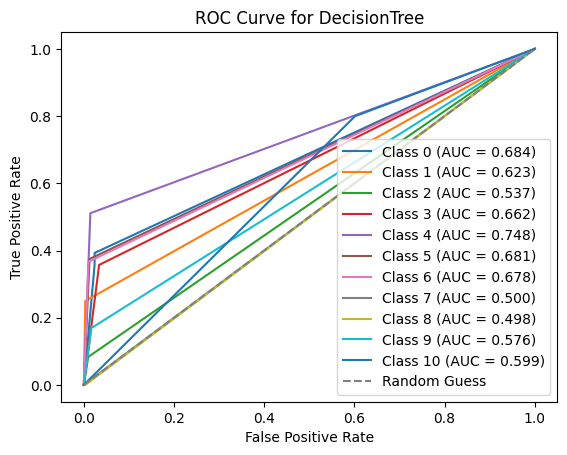

Classifier: RandomForest, Accuracy: 0.374 (+/- 0.083)


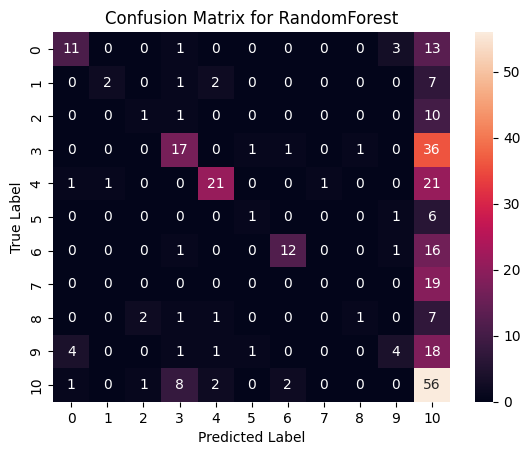

Classification Report for RandomForest:
                precision    recall  f1-score   support

         Dairy       0.65      0.39      0.49        28
        Drinks       0.67      0.17      0.27        12
   Fats & Oils       0.25      0.08      0.12        12
        Fruits       0.55      0.30      0.39        56
        Grains       0.78      0.47      0.58        45
Jams & Jellies       0.33      0.12      0.18         8
          Meat       0.80      0.40      0.53        30
       Seafood       0.00      0.00      0.00        19
  Seeds & Nuts       0.50      0.08      0.14        12
        Sweets       0.44      0.14      0.21        29
    Vegetables       0.27      0.80      0.40        70

      accuracy                           0.39       321
     macro avg       0.48      0.27      0.30       321
  weighted avg       0.50      0.39      0.37       321



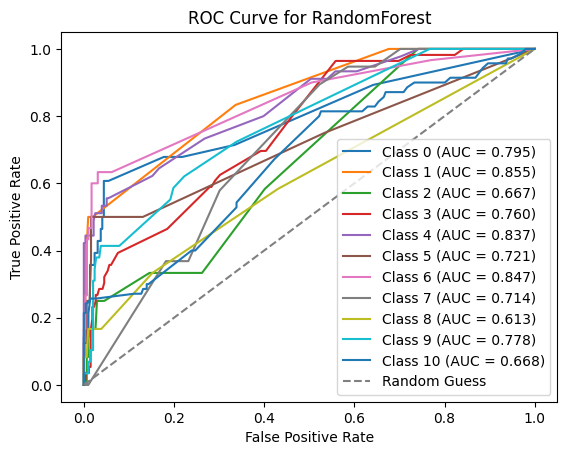

In [57]:
# Encode the categorical labels as integers
encoder = LabelEncoder()
y = encoder.fit_transform(df_foods['Category'])

# Create a bag of words representation of the food items
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df_foods['Food'])

# Define the classifiers to compare
classifiers = [MultinomialNB(), SVC(kernel="linear", probability=True), DecisionTreeClassifier(), RandomForestClassifier()]
classifier_names = ["MultinomialNB", "SVC", "DecisionTree", "RandomForest"]

# Perform cross-validation for each classifier
for clf, clf_name in zip(classifiers, classifier_names):
    scores = cross_val_score(clf, X, y, cv=5)
    print(f"Classifier: {clf_name}, Accuracy: {scores.mean():.3f} (+/- {scores.std() * 2:.3f})")

    # Predict class probabilities using cross-validation
    y_probas = cross_val_predict(clf, X, y, cv=5, method="predict_proba")

    # Get the class with the highest predicted probability for each sample
    y_pred = y_probas.argmax(axis=1)

    # Compute and plot the confusion matrix
    conf_mat = confusion_matrix(y, y_pred)
    sns.heatmap(conf_mat, annot=True, fmt="d")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix for {clf_name}")
    plt.show()

    # Print the classification report
    print(f"Classification Report for {clf_name}:")
    print(classification_report(y, y_pred, target_names=encoder.classes_))

    # Plot the ROC curve for each class
    plt.figure()
    for class_ in range(y.max() + 1):
        y_bin = (y == class_).astype(int)
        fpr, tpr, thresholds = roc_curve(y_bin, y_probas[:, class_])
        roc_auc = roc_auc_score(y_bin, y_probas[:, class_])
        plt.plot(fpr, tpr, label=f'Class {class_} (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {clf_name}')
    plt.legend()
    plt.show()

## Exploring scrape_me() function

In [25]:
import streamlit as st
import base64
import pandas as pd
import numpy as np
import json
import joblib

from time import sleep
from stqdm import stqdm
from recipe_scrapers import scrape_me
from stqdm import stqdm
from deep_translator import GoogleTranslator
from langdetect import detect
from fuzzywuzzy import process


def replace_measurement_symbols(ingredients):
    """
    Description:
    Converts measurement symbols to numbers that will later serve as floats

    Arguments:
    * ingredients: this is the ingredient list object
    """
    ingredients = [i.replace('¼', '0.25') for i in ingredients]
    ingredients = [i.replace('½', '0.5') for i in ingredients]
    ingredients = [i.replace('¾', '0.75') for i in ingredients]

    return ingredients


def justify(a, invalid_val=0, axis=1, side='left'):
    """
    Description:
    Justifies a 2D array i.e., this is used in create_df() below to merge all ingredient rows under each recipe column to eliminate NaN duplicates.

    Arguments:
    A : ndarray
        Input array to be justified
    axis : int
        Axis along which justification is to be made
    side : str
        Direction of justification. It could be 'left', 'right', 'up', 'down'
        It should be 'left' or 'right' for axis=1 and 'up' or 'down' for axis=0.
    """

    if invalid_val is np.nan:
        mask = pd.notnull(a)
    else:
        mask = a != invalid_val
    justified_mask = np.sort(mask, axis=axis)
    if (side == 'up') | (side == 'left'):
        justified_mask = np.flip(justified_mask, axis=axis)
    out = np.full(a.shape, invalid_val, dtype=object)
    if axis == 1:
        out[justified_mask] = a[mask]
    else:
        out.T[justified_mask.T] = a.T[mask.T]
    return out


def translate_ingredients(df):
    """
    Description:
    • Translates foods under "Ingredients" column from foreign language to English to prepare for food categorization

    Arguments:
    • df: this is the df created from scraping within the create_df function
    """
    ing_list = df['Ingredients'].to_list()
    ing_list_translated = GoogleTranslator(source=detect(', '.join(ing_list)), target='en').translate_batch(
        ing_list)  # Brings all the ingredients into a corpus to best detect the language
    df['Ingredient_Translated'] = ing_list_translated

    return df


def map_food_category(df):
    # fuzzywuzzy match
    score_cutoff = 90  # the higher this is, the more strict fuzzywuzzy is in looking for a match

    with open('foods.json') as f:
        foods_json = json.load(f)

    df_foods = pd.DataFrame(columns=['Category', 'Food'])

    for category, foods in foods_json.items():
        for food in foods:
            df_foods = df_foods.append({'Category': category, 'Food': food}, ignore_index=True)

    df['match'] = df['Ingredient_Translated'].apply(
        lambda x: process.extractOne(x, df_foods['Food'].tolist(), score_cutoff=score_cutoff)[0] if process.extractOne(
            x, df_foods['Food'].tolist(), score_cutoff=score_cutoff) else 'Unknown'
    )

    # create mapping
    mapping = df_foods.set_index('Food').to_dict()['Category']
    df['Category'] = df['match'].map(mapping)

    # fill missing values with classifier
    classifier = joblib.load('trained_SVC_model.joblib')
    missing_mask = df['Category'].isnull()
    missing_data = df[missing_mask].drop(['Category', 'match'], axis=1)

    # Vectorize the ingredients using the same bag of words representation
    vectorizer = joblib.load('vectorizer.joblib')
    ingredients_vectorized = vectorizer.transform(missing_data['Ingredient_Translated'].to_list())

    # make predictions using the classifier
    predictions = classifier.predict(ingredients_vectorized)
    df.loc[missing_mask, 'Category'] = predictions

    # fill remaining missing values with 'Unknown'
    df.loc[df['Category'].isnull(), 'Category'] = 'Unknown'
    cols = ['Ingredient_Translated', 'match']
    df = df.drop(columns=cols, axis=1)

    return df


def create_df(recipes):
    """
    Description:
    Creates one df with all recipes and their ingredients

    Arguments:
    * recipes: list of recipe URLs provided by user

    Comments:
    Note that ingredients with qualitative amounts e.g., "scheutje melk", "snufje zout" have been ommitted from the ingredient list
    """
    df_list = []

    for recipe in stqdm(recipes):
        scraper = scrape_me(recipe)
        recipe_details = replace_measurement_symbols(scraper.ingredients())

        recipe_name = recipe.split("https://www.hellofresh.nl/recipes/", 1)[1]
        recipe_name = recipe_name.rsplit('-', 1)[0]
        print("Processing data for " + recipe_name + " recipe.")

        for ingredient in recipe_details:
            try:
                df_temp = pd.DataFrame(columns=['Ingredients', 'Measurement'])
                df_temp[str(recipe_name)] = recipe_name

                ing_1 = ingredient.split("2 * ", 1)[1]
                ing_1 = ing_1.split(" ", 2)

                item = ing_1[2]
                measurement = ing_1[1]
                quantity = float(ing_1[0])

                df_temp.loc[len(df_temp)] = [item, measurement, quantity]
                df_list.append(df_temp)
            except (ValueError, IndexError) as e:
                pass

        df = pd.concat(df_list)

    print(
        "Renaming duplicate ingredients e.g., Kruimige aardappelen, Voorgekookte halve kriel met schil -> Aardappelen")
    ingredient_dict = {
        'Aardappelen': ('Dunne frieten', 'Half kruimige aardappelen', 'Voorgekookte halve kriel met schil',
                        'Kruimige aardappelen', 'Roodschillige aardappelen', 'Opperdoezer Ronde aardappelen'),
        'Ui': ('Rode ui'),
        'Kipfilet': ('Kipfilet met tuinkruiden en knoflook'),
        'Kipworst': ('Gekruide kipworst'),
        'Kipgehakt': (
        'Gemengd gekruid gehakt', 'Kipgehakt met Mexicaanse kruiden', 'Half-om-halfgehakt met Italiaanse kruiden',
        'Kipgehakt met tuinkruiden'),
        'Kipshoarma': ('Kalkoenshoarma')
    }

    reverse_label_ing = {x: k for k, v in ingredient_dict.items() for x in (v if isinstance(v, tuple) else (v,))}
    df["Ingredients"].replace(reverse_label_ing, inplace=True)

    print("Assigning ingredient categories")

    # Read food category JSON file
    with open("foods.json") as f:
        category_dict = json.load(f)

    reverse_label_cat = {x: k for k, v in category_dict.items() for x in v}
    df["Category"] = df["Ingredients"].map(reverse_label_cat)
    col = "Category"
    first_col = df.pop(col)
    df.insert(0, col, first_col)
    df = df.sort_values(['Category', 'Ingredients'], ascending=[True, True])

    print("Merging ingredients by row across all recipe columns using justify()")
    gp_cols = ['Ingredients', 'Measurement']
    oth_cols = df.columns.difference(gp_cols)

    arr = np.vstack(df.groupby(gp_cols, sort=False, dropna=False).apply(
        lambda gp: justify(gp.to_numpy(), invalid_val=np.NaN, axis=0, side='up')))

    # Reconstruct DataFrame
    # Remove entirely NaN rows based on the non-grouping columns
    res = (pd.DataFrame(arr, columns=df.columns)
           .dropna(how='all', subset=oth_cols, axis=0))

    res = res.fillna(0)
    res['Total'] = res.drop(['Ingredients', 'Measurement'], axis=1).sum(axis=1)
    res = res[res['Total'] != 0]  # To drop rows that are being duplicated with 0 for some reason; will check later

    # Place "Total" column towards front
    col = "Total"
    first_col = res.pop(col)
    res.insert(3, col, first_col)
    res = res.reset_index(drop=True)

    print("Translating foods to prepare for food category mapping")

    res = translate_ingredients(df=res)

    print("Mapping foods to categories")

    res = map_food_category(df=res)
    res = res.sort_values(by='Category').reset_index(drop=True)

    print("Processing complete!")

    return res

In [35]:
recipe = "https://www.hellofresh.nl/recipes/chicken-parmigiana-623c51bd7ed5c074f51bbb10"

scraper = scrape_me(recipe)
recipe_details = replace_measurement_symbols(scraper.ingredients())

recipe_name = recipe.split("https://www.hellofresh.nl/recipes/", 1)[1]
recipe_name = recipe_name.rsplit('-', 1)[0]
print("Processing data for " + recipe_name + " recipe.")

df_list = []

for ingredient in recipe_details:
    try:
        df_temp = pd.DataFrame(columns=['Ingredients', 'Measurement'])
        df_temp[str(recipe_name)] = recipe_name

        ing_1 = ingredient.split("2 * ", 1)[1]
        ing_1 = ing_1.split(" ", 2)

        item = ing_1[2]
        measurement = ing_1[1]
        quantity = float(ing_1[0])

        df_temp.loc[len(df_temp)] = [item, measurement, quantity]
        df_list.append(df_temp)
    except (ValueError, IndexError) as e:
        pass

df = pd.concat(df_list)

Processing data for chicken-parmigiana recipe.


In [37]:
scraper = scrape_me(recipe)
scraper.ingredients()

['2 * 500 gram Aardappelen',
 '2 * 1 stuk(s) Ui',
 '2 * 1 stuk(s) Knoflookteen',
 '2 * 1 zakje(s) Italiaanse kruiden',
 '2 * 200 gram Passata',
 '2 * 2 stuk(s) Kipfilet met tuinkruiden en knoflook',
 '2 * 50 gram Mayonaise',
 '2 * 50 gram Panko paneermeel',
 '2 * 1 stuk(s) Parmigiano reggiano',
 '2 * 1 stuk(s) Tomaat',
 '2 * 40 gram Rucola en veldsla',
 '2 * 2 el Olijfolie',
 '2 * naar smaak Peper en zout',
 '2 * 1.5 tl Zwarte balsamicoazijn',
 '2 * 1 tl Extra vierge olijfolie',
 '2 * 2 tl Suiker',
 '2 * 1 el [Plantaardige] roomboter']

In [32]:
recipe_details

['2 * 500 gram Aardappelen',
 '2 * 1 stuk(s) Ui',
 '2 * 1 stuk(s) Knoflookteen',
 '2 * 1 zakje(s) Italiaanse kruiden',
 '2 * 200 gram Passata',
 '2 * 2 stuk(s) Kipfilet met tuinkruiden en knoflook',
 '2 * 50 gram Mayonaise',
 '2 * 50 gram Panko paneermeel',
 '2 * 1 stuk(s) Parmigiano reggiano',
 '2 * 1 stuk(s) Tomaat',
 '2 * 40 gram Rucola en veldsla',
 '2 * 2 el Olijfolie',
 '2 * naar smaak Peper en zout',
 '2 * 1.5 tl Zwarte balsamicoazijn',
 '2 * 1 tl Extra vierge olijfolie',
 '2 * 2 tl Suiker',
 '2 * 1 el [Plantaardige] roomboter']

In [31]:
ingredient

'2 * 1 el [Plantaardige] roomboter'

In [30]:
ing_1

['1', 'el', '[Plantaardige] roomboter']

In [26]:
recipes = ["https://www.hellofresh.nl/recipes/chicken-parmigiana-623c51bd7ed5c074f51bbb10"]

create_df(recipes)

Processing data for chicken-parmigiana recipe.
Renaming duplicate ingredients e.g., Kruimige aardappelen, Voorgekookte halve kriel met schil -> Aardappelen
Assigning ingredient categories
Merging ingredients by row across all recipe columns using justify()
Translating foods to prepare for food category mapping


Mapping foods to categories
Processing complete!


/home/codespace/.local/lib/python3.10/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator SVC from version 1.2.0 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/codespace/.local/lib/python3.10/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator CountVectorizer from version 1.2.0 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


,Category,Ingredients,Measurement,Total,chicken-parmigiana
0,Fats & Oils,Extra vierge olijfolie,tl,1.0,1.0
1,Fats & Oils,Mayonaise,gram,50.0,50.0
2,Fats & Oils,Olijfolie,el,2.0,2.0
3,Fats & Oils,[Plantaardige] roomboter,el,1.0,1.0
4,Meat,Kipfilet,stuk(s),2.0,2.0
5,Sweets,Italiaanse kruiden,zakje(s),1.0,1.0
6,Sweets,Suiker,tl,2.0,2.0
7,Vegetables,Aardappelen,gram,500.0,500.0
8,Vegetables,Knoflookteen,stuk(s),1.0,1.0
9,Vegetables,Panko paneermeel,gram,50.0,50.0


In [22]:
import os
print(os.getcwd())

/workspaces/RecipeScraper/exploration


In [4]:
scraper = scrape_me("https://www.hellofresh.nl/recipes/chicken-parmigiana-623c51bd7ed5c074f51bbb10")

In [6]:
scraper.ingredients()

['2 * 500 gram Aardappelen',
 '2 * 1 stuk(s) Ui',
 '2 * 1 stuk(s) Knoflookteen',
 '2 * 1 zakje(s) Italiaanse kruiden',
 '2 * 200 gram Passata',
 '2 * 2 stuk(s) Kipfilet met tuinkruiden en knoflook',
 '2 * 50 gram Mayonaise',
 '2 * 50 gram Panko paneermeel',
 '2 * 1 stuk(s) Parmigiano reggiano',
 '2 * 1 stuk(s) Tomaat',
 '2 * 40 gram Rucola en veldsla',
 '2 * 2 el Olijfolie',
 '2 * naar smaak Peper en zout',
 '2 * 1.5 tl Zwarte balsamicoazijn',
 '2 * 1 tl Extra vierge olijfolie',
 '2 * 2 tl Suiker',
 '2 * 1 el [Plantaardige] roomboter']

# Expanding to all websites

In [39]:
import streamlit as st
import base64
import pandas as pd
import numpy as np
import json
import joblib

from time import sleep
from stqdm import stqdm
from recipe_scrapers import scrape_me
from stqdm import stqdm
from deep_translator import GoogleTranslator
from langdetect import detect
from fuzzywuzzy import process


def replace_measurement_symbols(ingredients):
    """
    Description:
    Converts measurement symbols to numbers that will later serve as floats

    Arguments:
    * ingredients: this is the ingredient list object
    """
    ingredients = [i.replace('¼', '0.25') for i in ingredients]
    ingredients = [i.replace('½', '0.5') for i in ingredients]
    ingredients = [i.replace('⅔', '0.667') for i in ingredients]
    ingredients = [i.replace('¾', '0.75') for i in ingredients]

    return ingredients


def justify(a, invalid_val=0, axis=1, side='left'):
    """
    Description:
    Justifies a 2D array i.e., this is used in create_df() below to merge all ingredient rows under each recipe column to eliminate NaN duplicates.

    Arguments:
    A : ndarray
        Input array to be justified
    axis : int
        Axis along which justification is to be made
    side : str
        Direction of justification. It could be 'left', 'right', 'up', 'down'
        It should be 'left' or 'right' for axis=1 and 'up' or 'down' for axis=0.
    """

    if invalid_val is np.nan:
        mask = pd.notnull(a)
    else:
        mask = a != invalid_val
    justified_mask = np.sort(mask, axis=axis)
    if (side == 'up') | (side == 'left'):
        justified_mask = np.flip(justified_mask, axis=axis)
    out = np.full(a.shape, invalid_val, dtype=object)
    if axis == 1:
        out[justified_mask] = a[mask]
    else:
        out.T[justified_mask.T] = a.T[mask.T]
    return out


def translate_ingredients(df):
    """
    Description:
    • Translates foods under "Ingredients" column from foreign language to English to prepare for food categorization

    Arguments:
    • df: this is the df created from scraping within the create_df function
    """
    ing_list = df['Ingredients'].to_list()
    ing_list_translated = GoogleTranslator(source=detect(', '.join(ing_list)), target='en').translate_batch(
        ing_list)  # Brings all the ingredients into a corpus to best detect the language
    df['Ingredient_Translated'] = ing_list_translated

    return df


def map_food_category(df):
    # fuzzywuzzy match
    score_cutoff = 90  # the higher this is, the more strict fuzzywuzzy is in looking for a match

    with open('foods.json') as f:
        foods_json = json.load(f)

    df_foods = pd.DataFrame(columns=['Category', 'Food'])

    for category, foods in foods_json.items():
        for food in foods:
            df_foods = df_foods.append({'Category': category, 'Food': food}, ignore_index=True)

    df['match'] = df['Ingredient_Translated'].apply(
        lambda x: process.extractOne(x, df_foods['Food'].tolist(), score_cutoff=score_cutoff)[0] if process.extractOne(
            x, df_foods['Food'].tolist(), score_cutoff=score_cutoff) else 'Unknown'
    )

    # create mapping
    mapping = df_foods.set_index('Food').to_dict()['Category']
    df['Category'] = df['match'].map(mapping)

    # fill missing values with classifier
    classifier = joblib.load('trained_SVC_model.joblib')
    missing_mask = df['Category'].isnull()
    missing_data = df[missing_mask].drop(['Category', 'match'], axis=1)

    # Vectorize the ingredients using the same bag of words representation
    vectorizer = joblib.load('vectorizer.joblib')
    ingredients_vectorized = vectorizer.transform(missing_data['Ingredient_Translated'].to_list())

    # make predictions using the classifier
    predictions = classifier.predict(ingredients_vectorized)
    df.loc[missing_mask, 'Category'] = predictions

    # fill remaining missing values with 'Unknown'
    df.loc[df['Category'].isnull(), 'Category'] = 'Unknown'
    cols = ['Ingredient_Translated', 'match']
    df = df.drop(columns=cols, axis=1)

    return df


def create_df(recipes, num_people=1):
    """
    Description:
    Creates one df with all recipes and their ingredients

    Arguments:
    * recipes: list of recipe URLs provided by user

    Comments:
    Note that ingredients with qualitative amounts e.g., "scheutje melk", "snufje zout" have been ommitted from the ingredient list
    """
    df_list = []

    for recipe in stqdm(recipes):
        scraper = scrape_me(recipe)
        recipe_details = replace_measurement_symbols(scraper.ingredients())

        recipe_name = recipe.split("recipes/", 1)[1]
        recipe_name = recipe_name.rsplit('-', 1)[0]
        print("Processing data for " + recipe_name + " recipe.")

        for ingredient in recipe_details:
            try:
                df_temp = pd.DataFrame(columns=['Ingredients', 'Measurement'])
                df_temp[str(recipe_name)] = recipe_name

                ing_1 = ingredient.split("2 * ", 1)[1]
                ing_1 = ing_1.split(" ", 2)

                item = ing_1[2]
                measurement = ing_1[1]
                quantity = float(ing_1[0])/2 * num_people

                df_temp.loc[len(df_temp)] = [item, measurement, quantity]
                df_list.append(df_temp)
            except (ValueError, IndexError) as e:
                pass

        df = pd.concat(df_list)

    print(
        "Renaming duplicate ingredients e.g., Kruimige aardappelen, Voorgekookte halve kriel met schil -> Aardappelen")
    ingredient_dict = {
        'Aardappelen': ('Dunne frieten', 'Half kruimige aardappelen', 'Voorgekookte halve kriel met schil',
                        'Kruimige aardappelen', 'Roodschillige aardappelen', 'Opperdoezer Ronde aardappelen'),
        'Ui': ('Rode ui'),
        'Kipfilet': ('Kipfilet met tuinkruiden en knoflook'),
        'Kipworst': ('Gekruide kipworst'),
        'Kipgehakt': (
        'Gemengd gekruid gehakt', 'Kipgehakt met Mexicaanse kruiden', 'Half-om-halfgehakt met Italiaanse kruiden',
        'Kipgehakt met tuinkruiden'),
        'Kipshoarma': ('Kalkoenshoarma')
    }

    reverse_label_ing = {x: k for k, v in ingredient_dict.items() for x in (v if isinstance(v, tuple) else (v,))}
    df["Ingredients"].replace(reverse_label_ing, inplace=True)

    print("Assigning ingredient categories")

    # Read food category JSON file
    with open('foods.json') as f:
        category_dict = json.load(f)

    reverse_label_cat = {x: k for k, v in category_dict.items() for x in v}
    df["Category"] = df["Ingredients"].map(reverse_label_cat)
    col = "Category"
    first_col = df.pop(col)
    df.insert(0, col, first_col)
    df = df.sort_values(['Category', 'Ingredients'], ascending=[True, True])

    print("Merging ingredients by row across all recipe columns using justify()")
    gp_cols = ['Ingredients', 'Measurement']
    oth_cols = df.columns.difference(gp_cols)

    arr = np.vstack(df.groupby(gp_cols, sort=False, dropna=False).apply(
        lambda gp: justify(gp.to_numpy(), invalid_val=np.NaN, axis=0, side='up')))

    # Reconstruct DataFrame
    # Remove entirely NaN rows based on the non-grouping columns
    res = (pd.DataFrame(arr, columns=df.columns)
           .dropna(how='all', subset=oth_cols, axis=0))

    res = res.fillna(0)
    res['Total'] = res.drop(['Ingredients', 'Measurement'], axis=1).sum(axis=1)
    res = res[res['Total'] != 0]  # To drop rows that are being duplicated with 0 for some reason; will check later

    # Place "Total" column towards front
    col = "Total"
    first_col = res.pop(col)
    res.insert(3, col, first_col)
    res = res.reset_index(drop=True)

    print("Translating foods to prepare for food category mapping")

    res = translate_ingredients(df=res)

    print("Mapping foods to categories")

    res = map_food_category(df=res)
    res = res.sort_values(by='Category').reset_index(drop=True)

    print("Processing complete!")

    return res

In [40]:
recipes = [
    'https://www.hellofresh.com/recipes/sizzling-southwestern-chicken-59c42774a5ed19691435c2b2',
    'https://www.hellofresh.com/recipes/teriyaki-chicken-tenders-5a664231ad1d6c6f007d0d72',
    'https://www.hellofresh.com/recipes/one-pan-orzo-italiano-5a6f445430006c79a749c0f2',
]

check_df = create_df(recipes=recipes, num_people=6)
check_df

Processing data for sizzling-southwestern-chicken recipe.
Processing data for teriyaki-chicken-tenders recipe.
Processing data for one-pan-orzo-italiano recipe.
Renaming duplicate ingredients e.g., Kruimige aardappelen, Voorgekookte halve kriel met schil -> Aardappelen
Assigning ingredient categories
Merging ingredients by row across all recipe columns using justify()
Translating foods to prepare for food category mapping
Mapping foods to categories



/tmp/ipykernel_15181/2062876452.py:205: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  res['Total'] = res.drop(['Ingredients', 'Measurement'], axis=1).sum(axis=1)


Processing complete!


,Category,Ingredients,Measurement,Total,sizzling-southwestern-chicken,teriyaki-chicken-tenders,one-pan-orzo-italiano
0,Dairy,Parmesan Cheese,cup,0.750,0.0,0.00,0.750
1,Dairy,Mozzarella Cheese,cup,0.750,0.0,0.00,0.750
2,Dairy,Feta Cheese,cup,1.500,1.5,0.00,0.000
3,Dairy,Cornstarch,teaspoon,3.000,0.0,3.00,0.000
4,Fats & Oils,Olive Oil,teaspoon,15.000,12.0,0.00,3.000
5,Fats & Oils,Vegetable Oil,teaspoon,18.000,0.0,18.00,0.000
6,Fruits,Lime,unit,6.000,3.0,3.00,0.000
7,Grains,Jasmine Rice,cup,4.500,0.0,4.50,0.000
8,Grains,White Wine Vinegar,tablespoon,6.000,0.0,6.00,0.000
9,Meat,Chicken Stock Concentrate,unit,3.000,0.0,0.00,3.000
